In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
#machine learning
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
# machine learning
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from google.colab import drive
drive.mount('/content/drive')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
df = pd.read_csv('/content/drive/MyDrive/MINI PROJECT/disaster_tweets .csv')
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Target Distribution

<Axes: ylabel='count'>

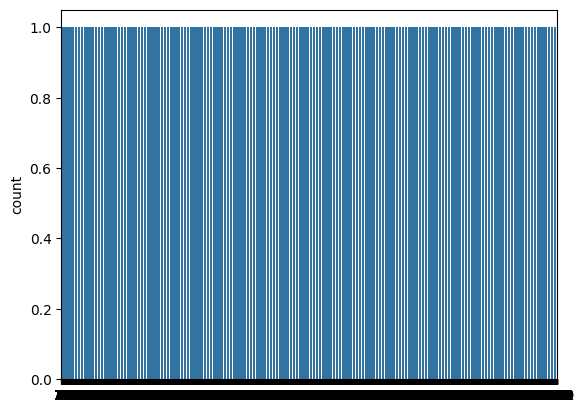

In [4]:

sns.countplot(df.target)

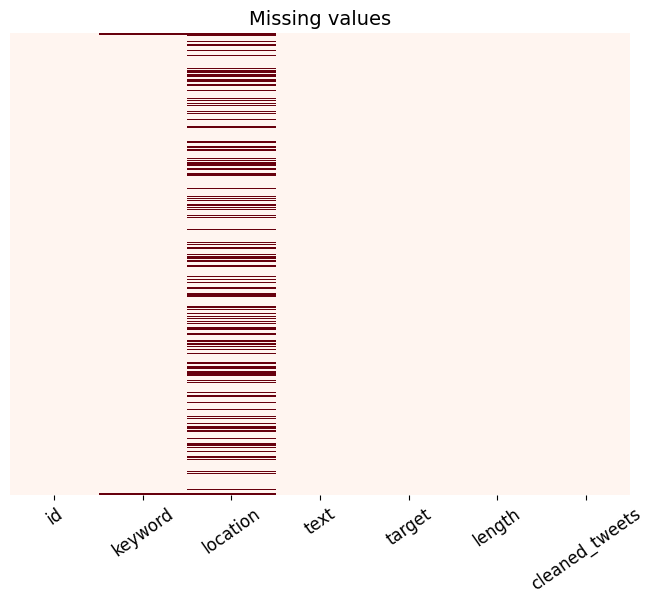

In [59]:
plt.figure(figsize = (8, 6))
sns.heatmap(df.isna(), yticklabels = False, cbar = False, cmap = 'Reds')
plt.title("Missing values", fontsize = 14)
plt.xticks(rotation = 35, fontsize = 12)
plt.show()

<ipython-input-61-21fbc61f0ed2>:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



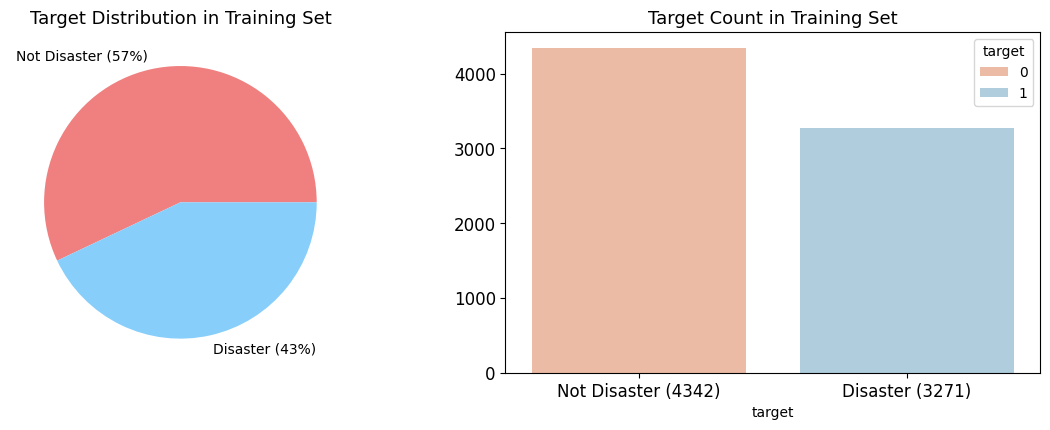

In [61]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
plt.tight_layout()

df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'],colors=['lightcoral','lightskyblue'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1], palette="RdBu")

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [5]:
# craeteing new column for storing length of reviews
df['length'] = df['text'].apply(len)
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  length  
0       1      69  
1       1      38  
2       1     133  
3       1      65  
4       1      88

<Axes: ylabel='Frequency'>

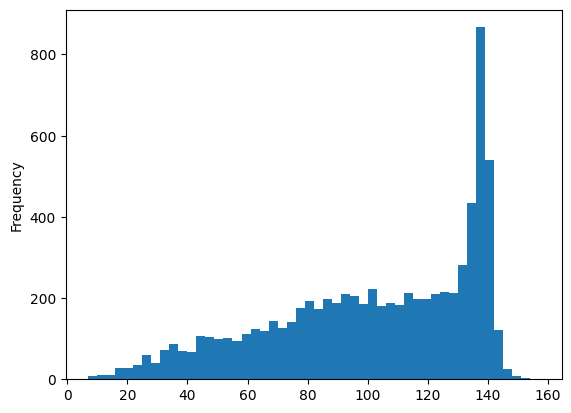

In [6]:
df['length'].plot(bins=50, kind='hist')

In [7]:
import plotly.graph_objects as go

# Create the bar chart
fig = go.Figure(data=[
    go.Bar(x=["0", "1"], y=df["target"].value_counts(), marker_color=["red", "goldenrod"])
])

# Customize the bar chart
fig.update_layout(
    title="Counts for Disaster and Non-Disaster Tweets",
    xaxis_title="Targets",
    yaxis_title="Count",
    width=800,
    height=550,
    showlegend=False
)

# Show the plot
fig.show()


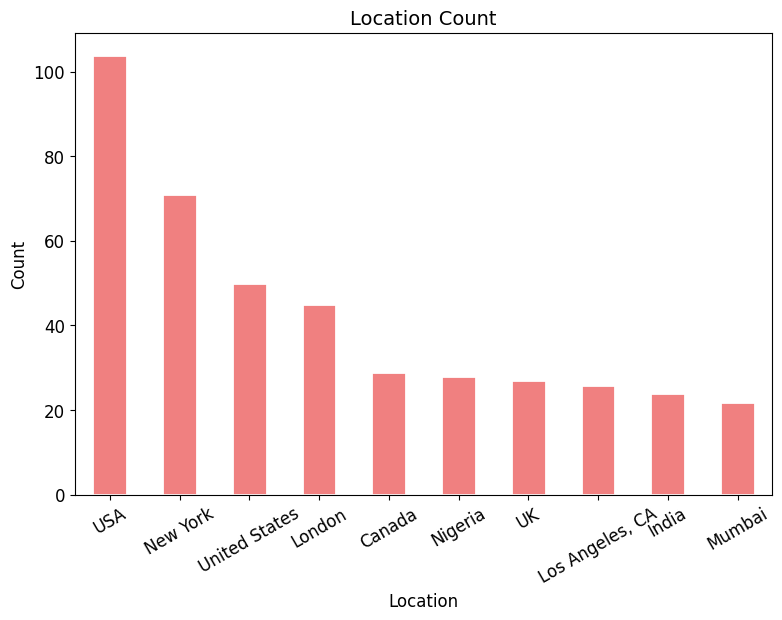

In [62]:
plt.figure(figsize = (9, 6))
ax = plt.axes()
ax.set_facecolor('white')
ax = ((df.location.value_counts())[:10]).plot(kind = 'bar', color = 'lightcoral', linewidth = 2, edgecolor = 'white')
plt.title('Location Count', fontsize = 14)
plt.xlabel('Location', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
ax.xaxis.set_tick_params(labelsize = 12, rotation = 30)
ax.yaxis.set_tick_params(labelsize = 12)

In [8]:
from plotly.subplots import make_subplots

word_len_dis = df[df['target']==1]['text'].str.split().map(lambda x : len(x))

word_len_non_dis = df[df['target']==0]['text'].str.split().map(lambda x : len(x))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
            go.Histogram(x=word_len_dis,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=1
).add_trace(
            go.Histogram(x=word_len_non_dis,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=2
).update_layout(title_text="Length of words in Tweets",title_x=0.5,showlegend=False).show()


In [65]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium import plugins

new_df = pd.DataFrame()
new_df['location'] = ((df['location'].value_counts())[:10]).index
new_df['count'] = ((df['location'].value_counts())[:10]).values
geolocator = Nominatim(user_agent = 'Rahil')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 0.5)
lat = {}
long = {}
for i in new_df['location']:
    location = geocode(i)
    lat[i] = location.latitude
    long[i] = location.longitude
new_df['latitude'] = new_df['location'].map(lat)
new_df['longitude'] = new_df['location'].map(long)
map = folium.Map(location = [10.0, 10.0], tiles = 'CartoDB dark_matter', zoom_start = 1.5)
markers = []
title = '''<h1 align = "center" style = "font-size: 15px"><b>Top 10 Tweet Locations</b></h1>'''
for i, r in new_df.iterrows():
    loss = r['count']
    if r['count'] > 0:
        counts = r['count'] * 0.4
        folium.CircleMarker([float(r['latitude']), float(r['longitude'])], radius = float(counts), color = 'lightcoral', fill = True).add_to(map)
map.get_root().html.add_child(folium.Element(title))
map

In [10]:
import plotly.express as px
def avgwordlen(words):
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)


# Calculate average word length for disaster and non-disaster tweets
avgword_len_dis = df[df['target'] == 1]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))
avgword_len_non_dis = df[df['target'] == 0]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

# Create a DataFrame for Plotly Express
data = pd.DataFrame({'Disaster': avgword_len_dis, 'Non-Disaster': avgword_len_non_dis})

# Create a histogram
fig = px.histogram(data, histnorm='probability density', barmode='overlay', marginal='rug')

# Update layout
fig.update_layout(
    title="Average Word Length in Tweets",
    xaxis_title="Average Word Length",
    yaxis_title="Density",
    title_x=0.5
)

# Show the plot
fig.show()


In [11]:
df.length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [12]:
df[df['length'] == 157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

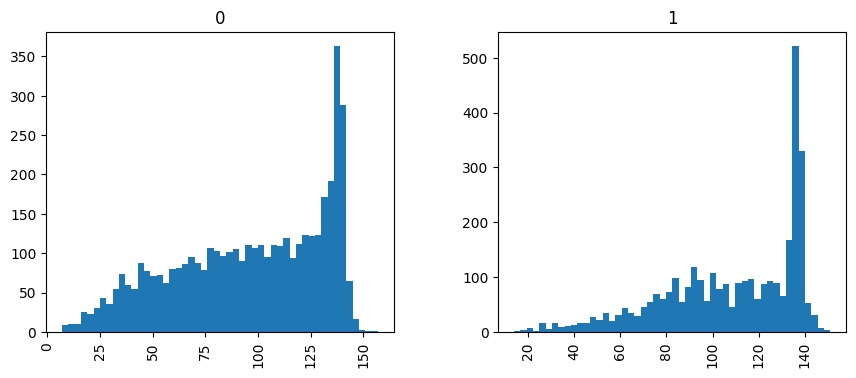

In [13]:
df.hist(column='length', by='target', bins=50,figsize=(10,4))

In [64]:
from wordcloud import STOPWORDS
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 50
DISASTER_TWEETS = df['target'] == 1
# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

for tweet in df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1

for tweet in df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1

df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1

for tweet in df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1

df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

Text(0.5, 1.0, 'Top 50 most common unigrams in Non-disaster Tweets')

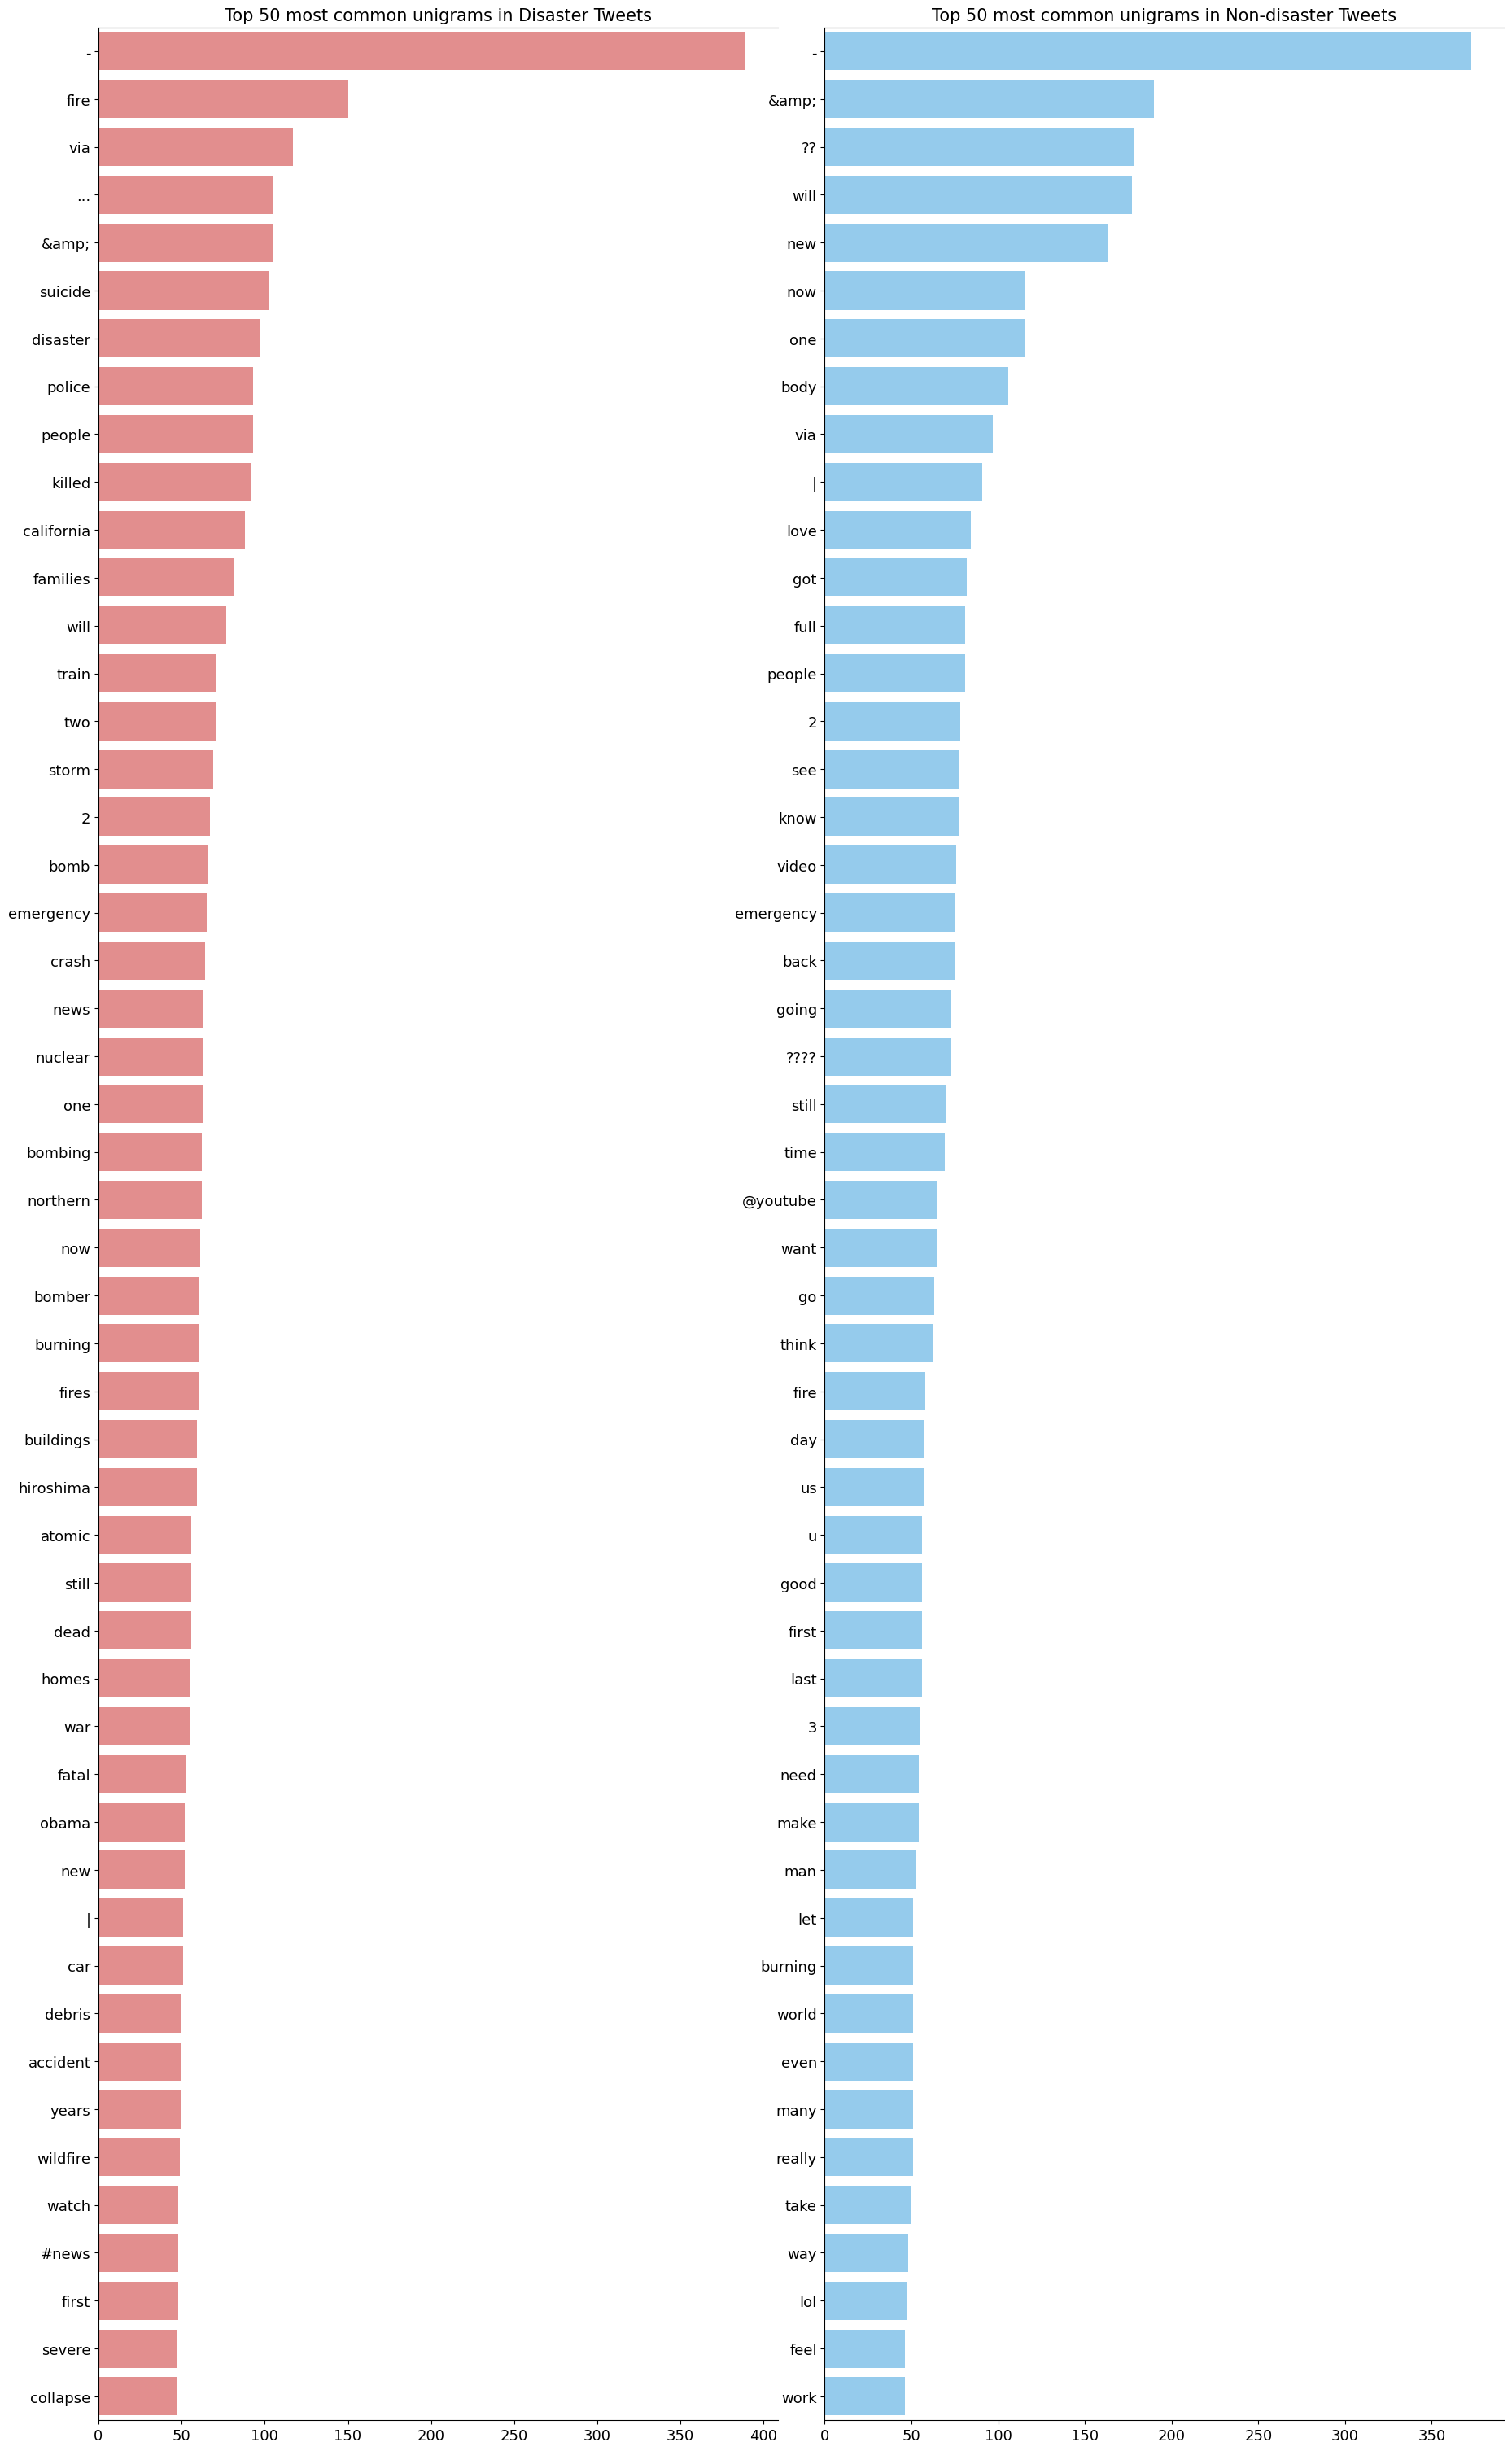

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='lightcoral')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='lightskyblue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 137 (\x89) missing from current font.



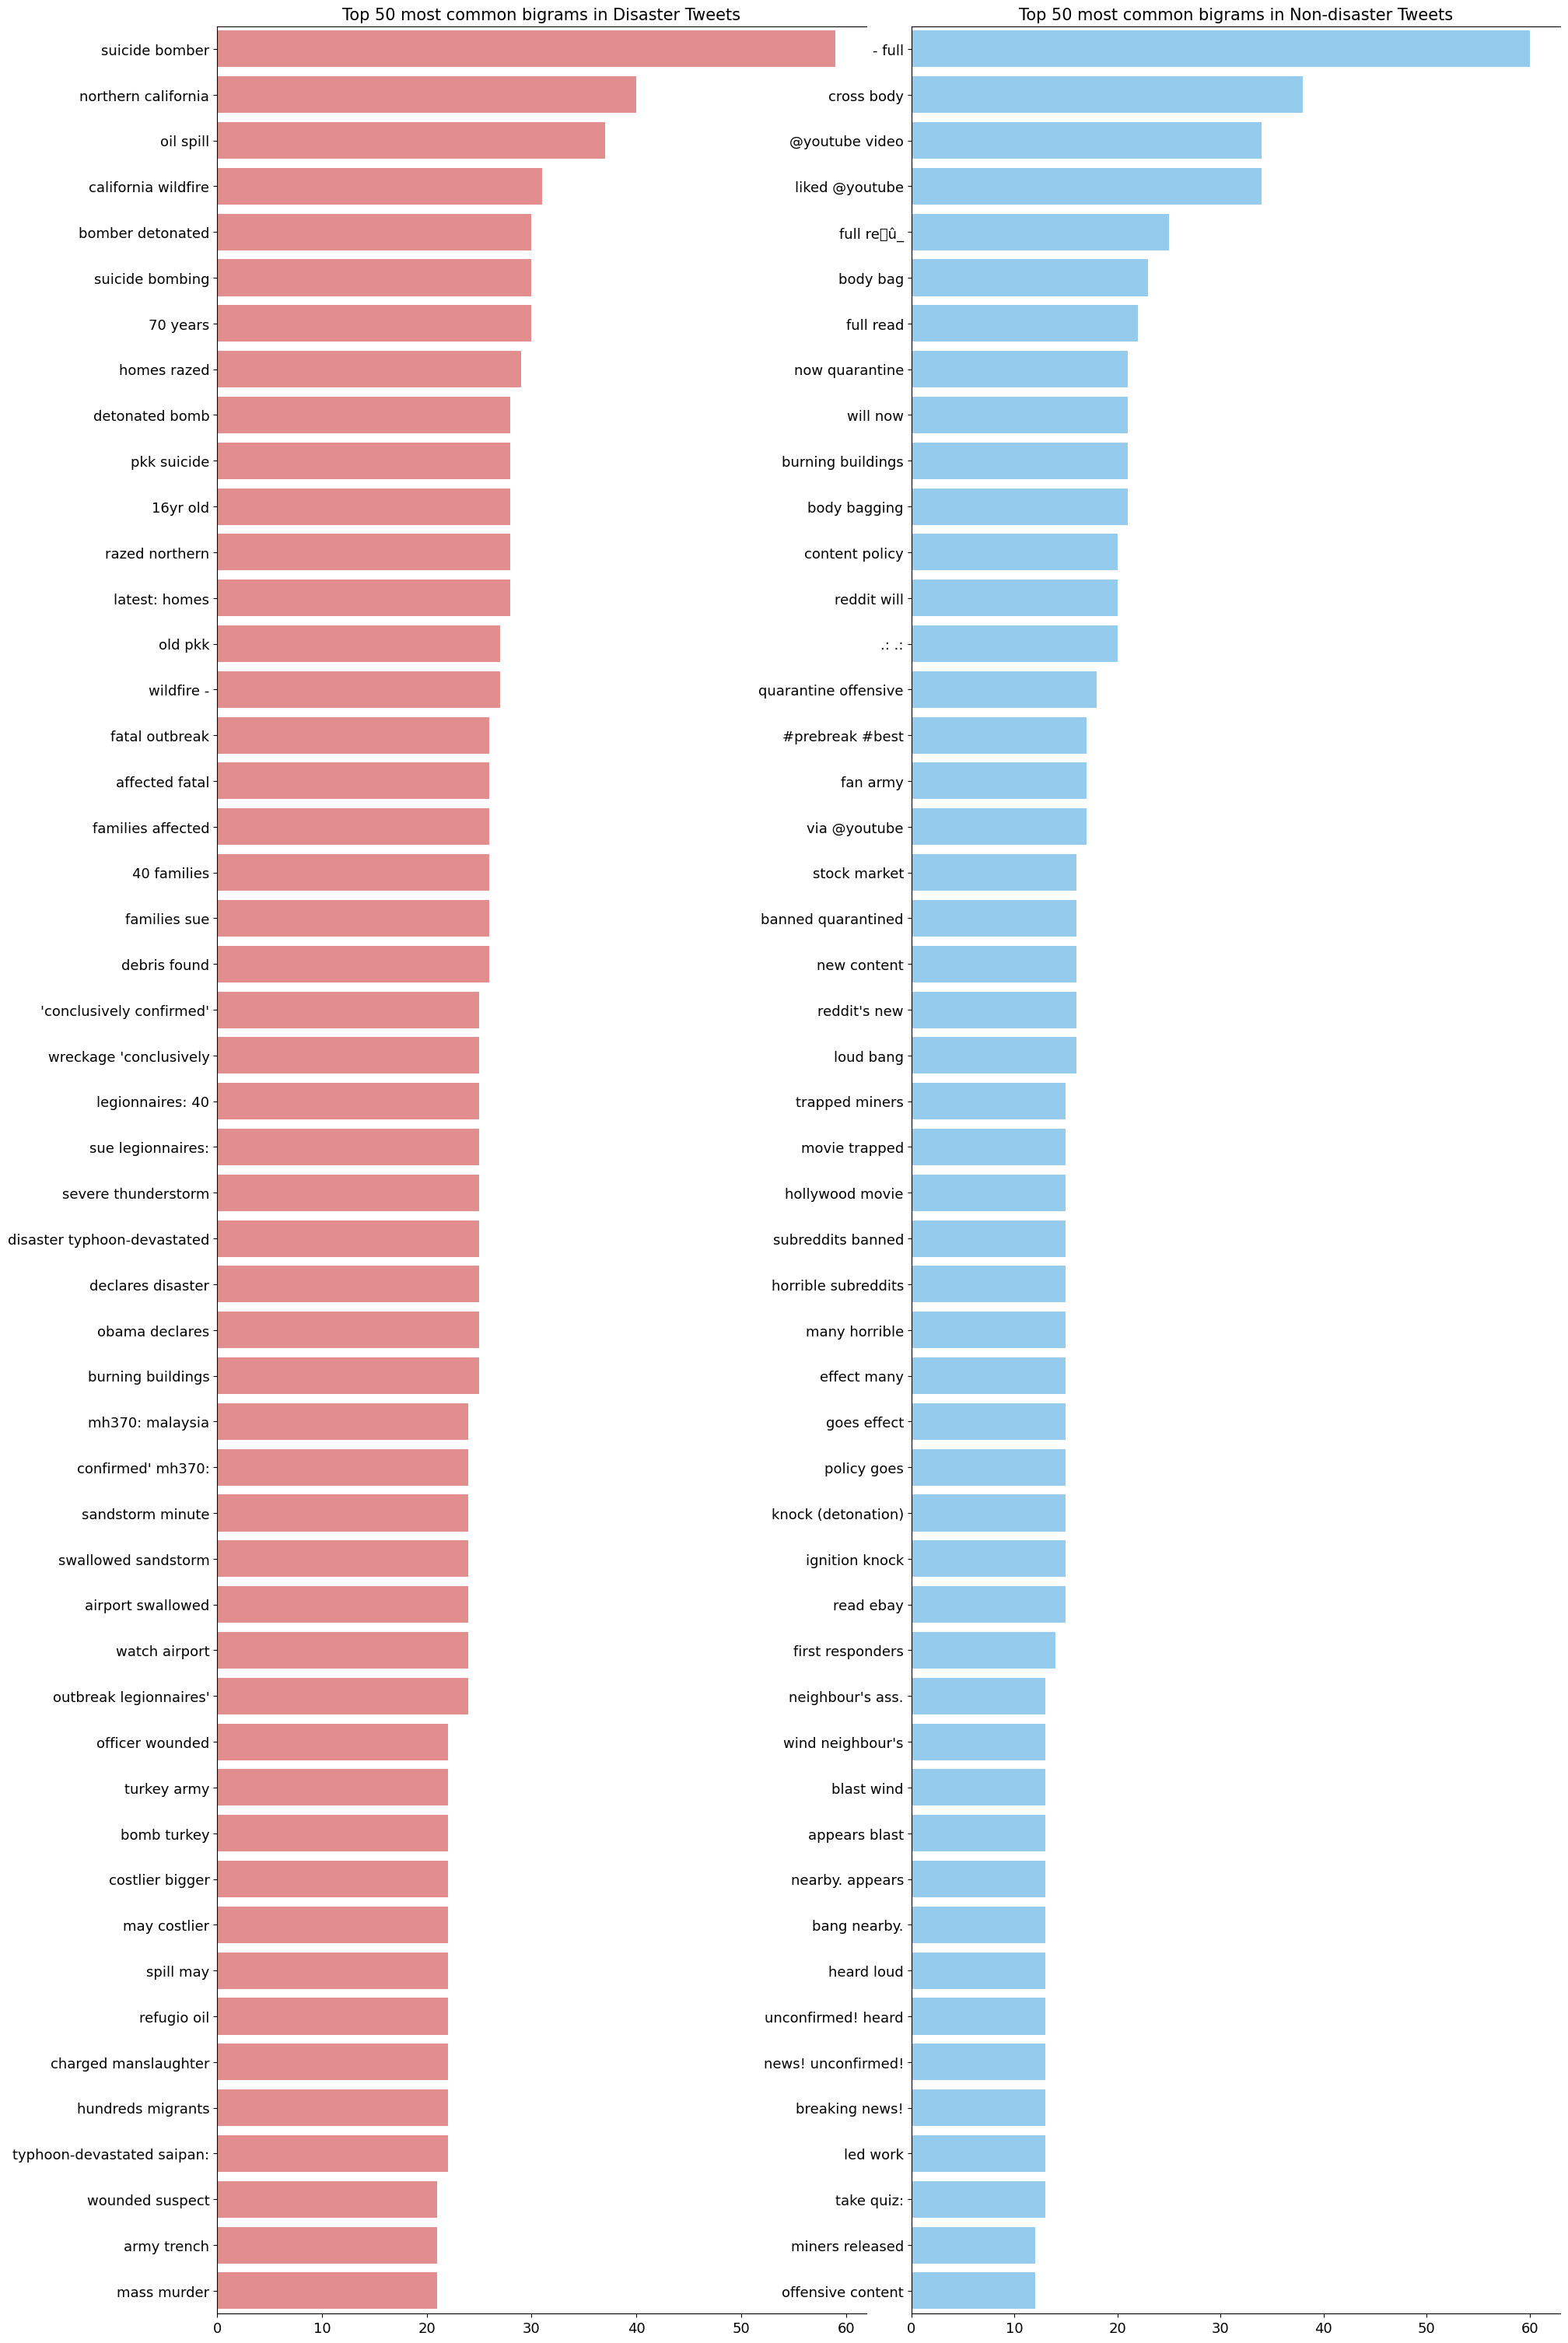

In [67]:
fig, axes = plt.subplots(ncols=2, figsize=(18,30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='lightcoral')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='lightskyblue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 137 (\x89) missing from current font.



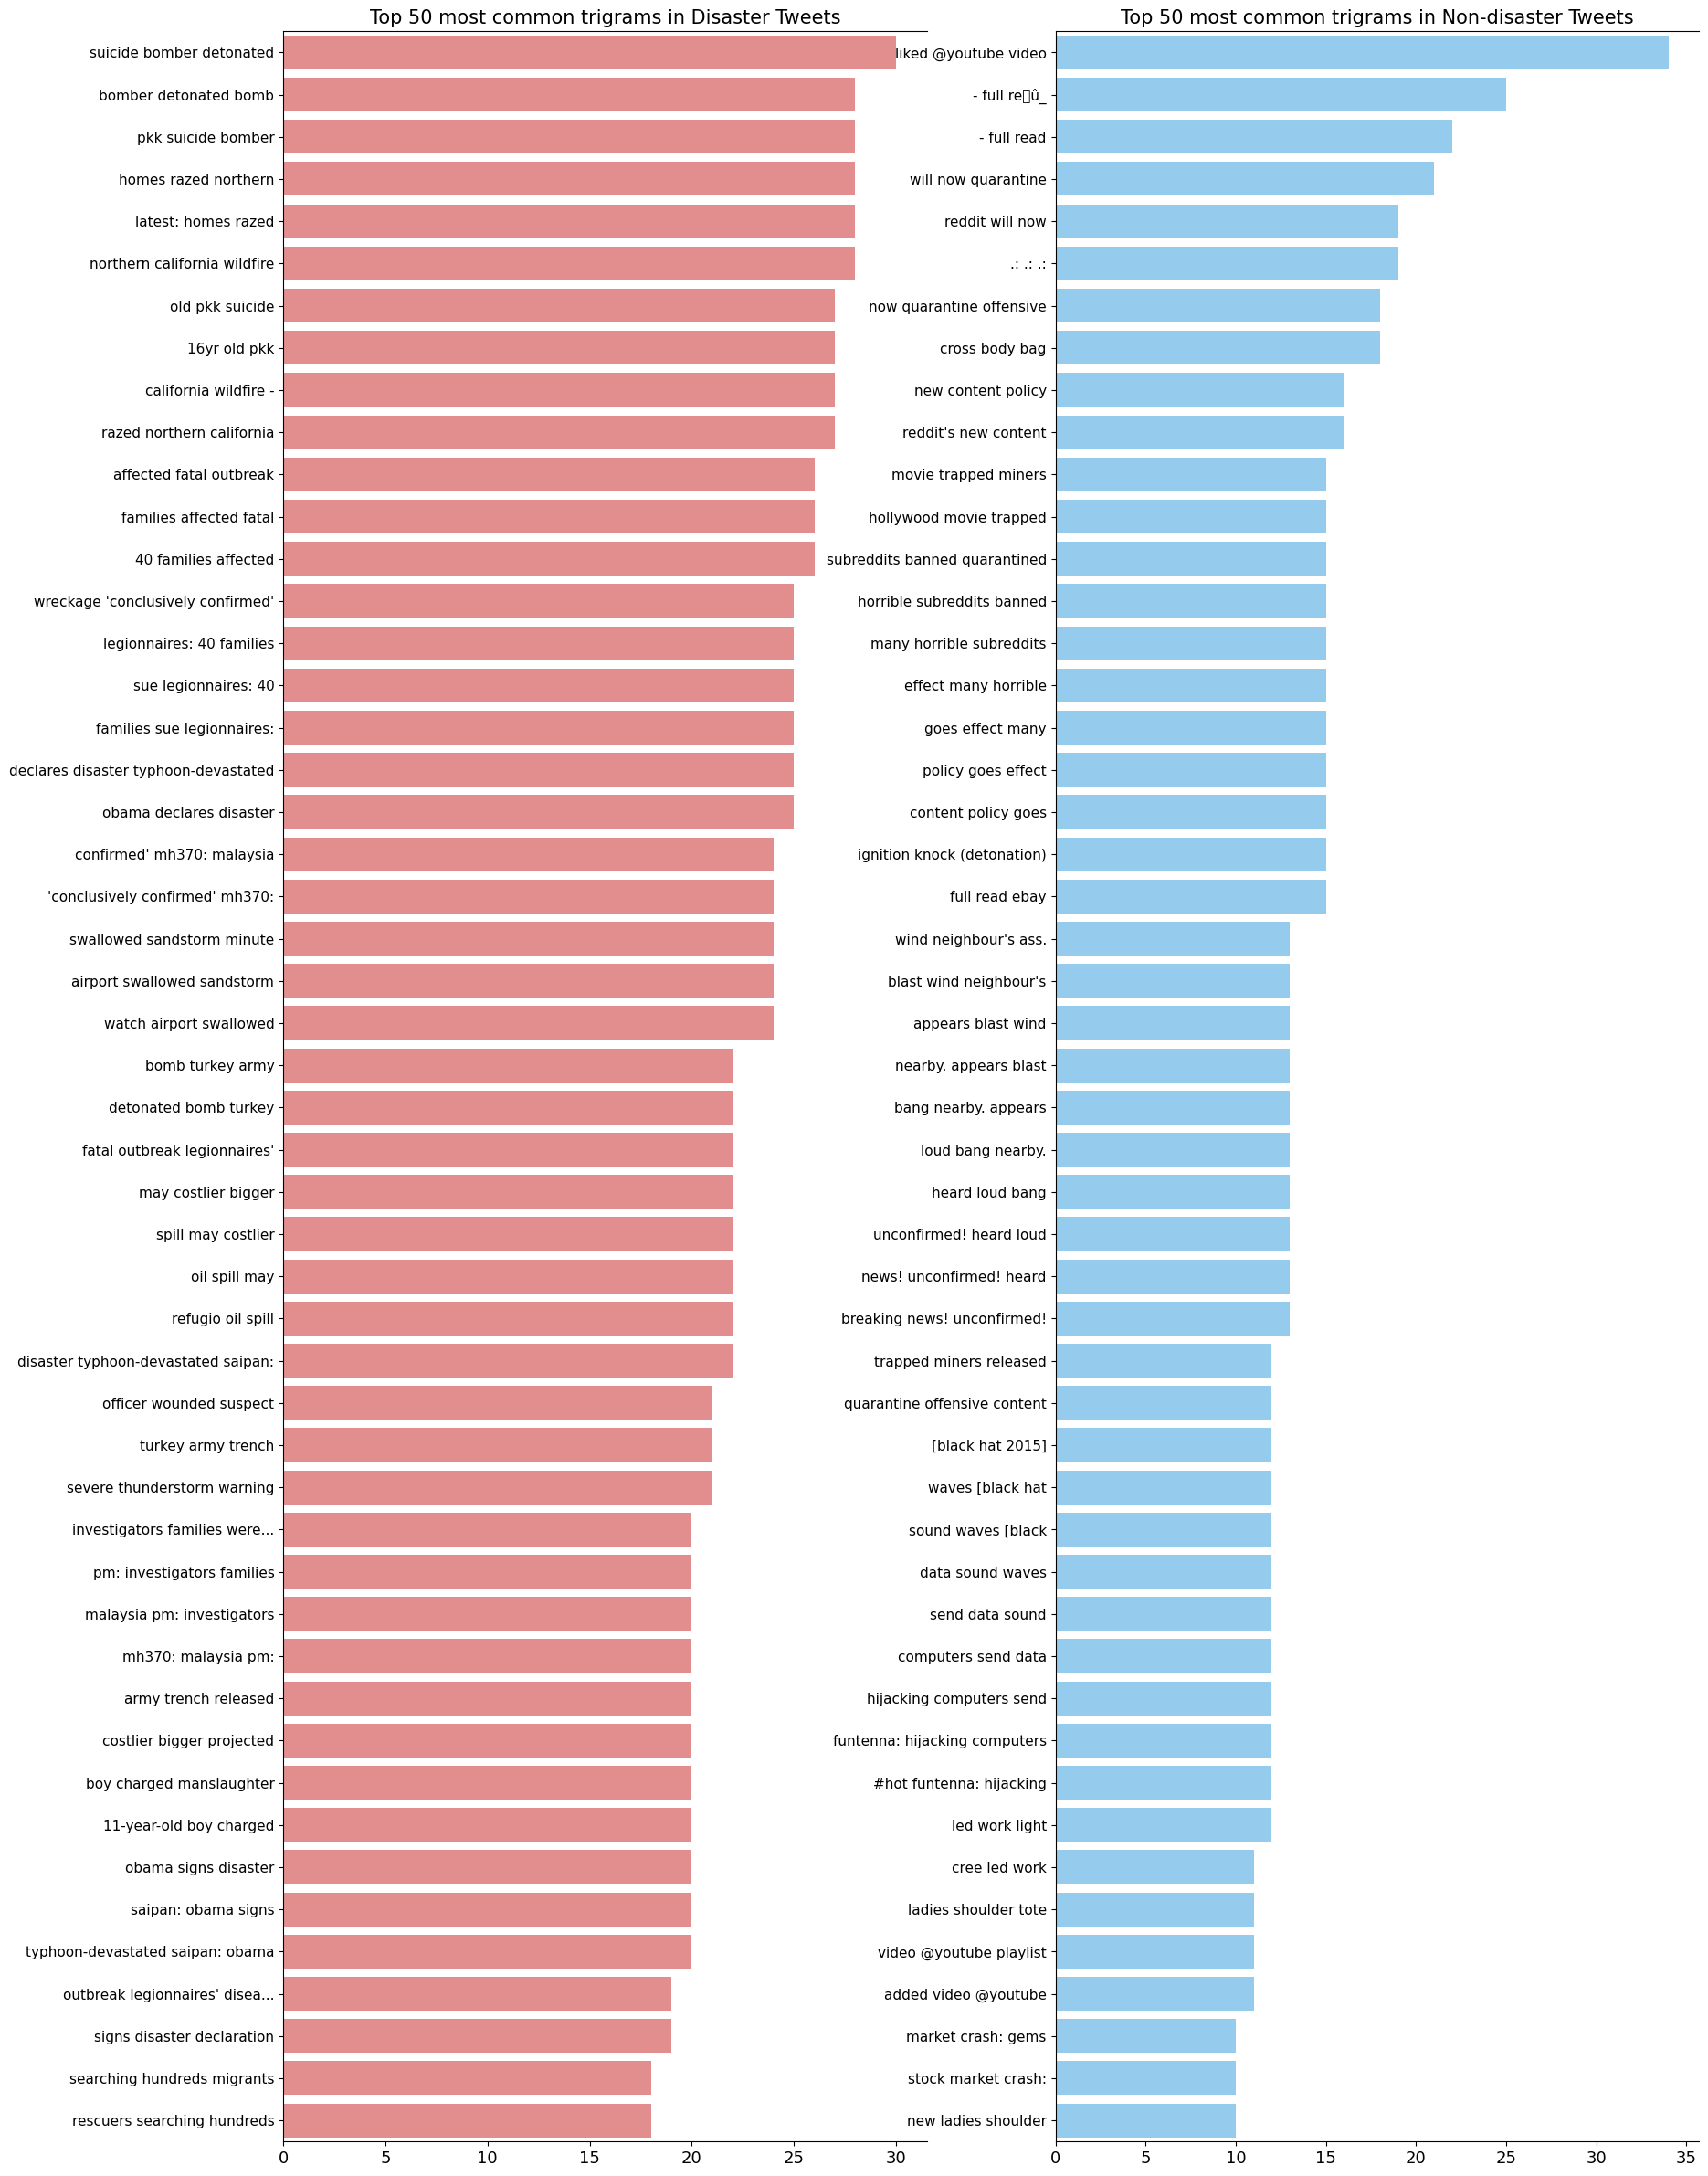

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 30), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='lightcoral')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='lightskyblue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [14]:
import re

# Function to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile(
        "[" u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)
df['text'] = df['text'].apply(remove_emojis)
df.to_csv('cleaned_twitter_dataset.csv', index=False)

In [15]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Removing stop words which are unneccesary from headline news
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

df_1 = df[df['target']==1]
df_0 = df[df['target']==0]
df_1['text']=df_1['text'].apply(remove_stopwords)
df_0['text']=df_0['text'].apply(remove_stopwords)

<ipython-input-15-812a15432658>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-812a15432658>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Visualising most common stop words in the text data

bold text
What is a corpus?
In linguistics and NLP, corpus (literally Latin for body) refers to a collection of texts.
Such collections may be formed of a single language of texts, or can span multiple languages

Function for creating sample corpus for further analysis.


In [16]:
def create_corpus(target):
    corpus = []
    for i in df[df['target']==target]['text'].str.split():
        for x in i:
            corpus.append(x)
    return corpus

In [17]:
from collections import defaultdict


In [20]:
values_list = []

def analyze_stopwords(data,func,targetlist):

  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)

    for word in corpus:
        dic[word] += 1

    top = sorted(dic.items(),key = lambda x: x[1],reverse=True)[:10]
    x_items,y_values = zip(*top)
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing stopwords for 0 and 1 target labels
analyze_stopwords(df,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
      go.Bar(x=values_list[1],y=values_list[0],orientation='h',marker=dict(color= 'rgba(152, 255, 74,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[3],y=values_list[2],orientation='h',marker=dict(color= 'rgba(255, 143, 92,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top stop words in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top stop words in the text',auto_open=False,show_link=False)

**
 Visualising most common punctuations in the text data

**

In [21]:
from string import punctuation
values_list = []
def analyze_punctuations(data,func,targetlist):

  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)

    for word in corpus:
        if word in punctuation:
            dic[word] += 1
    x_items, y_values = zip(*dic.items())
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing punctuations for 0 and 1 target labels
analyze_punctuations(df,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
      go.Bar(x=values_list[0],y=values_list[1],
             marker=dict(color= 'rgba(196, 94, 255,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[2],y=values_list[3],
             marker=dict(color= 'rgba(255, 163, 102,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top Punctuations in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top Punctuations in the text',auto_open=False,show_link=False)

## Plotting wordcloud of Disaster Tweets

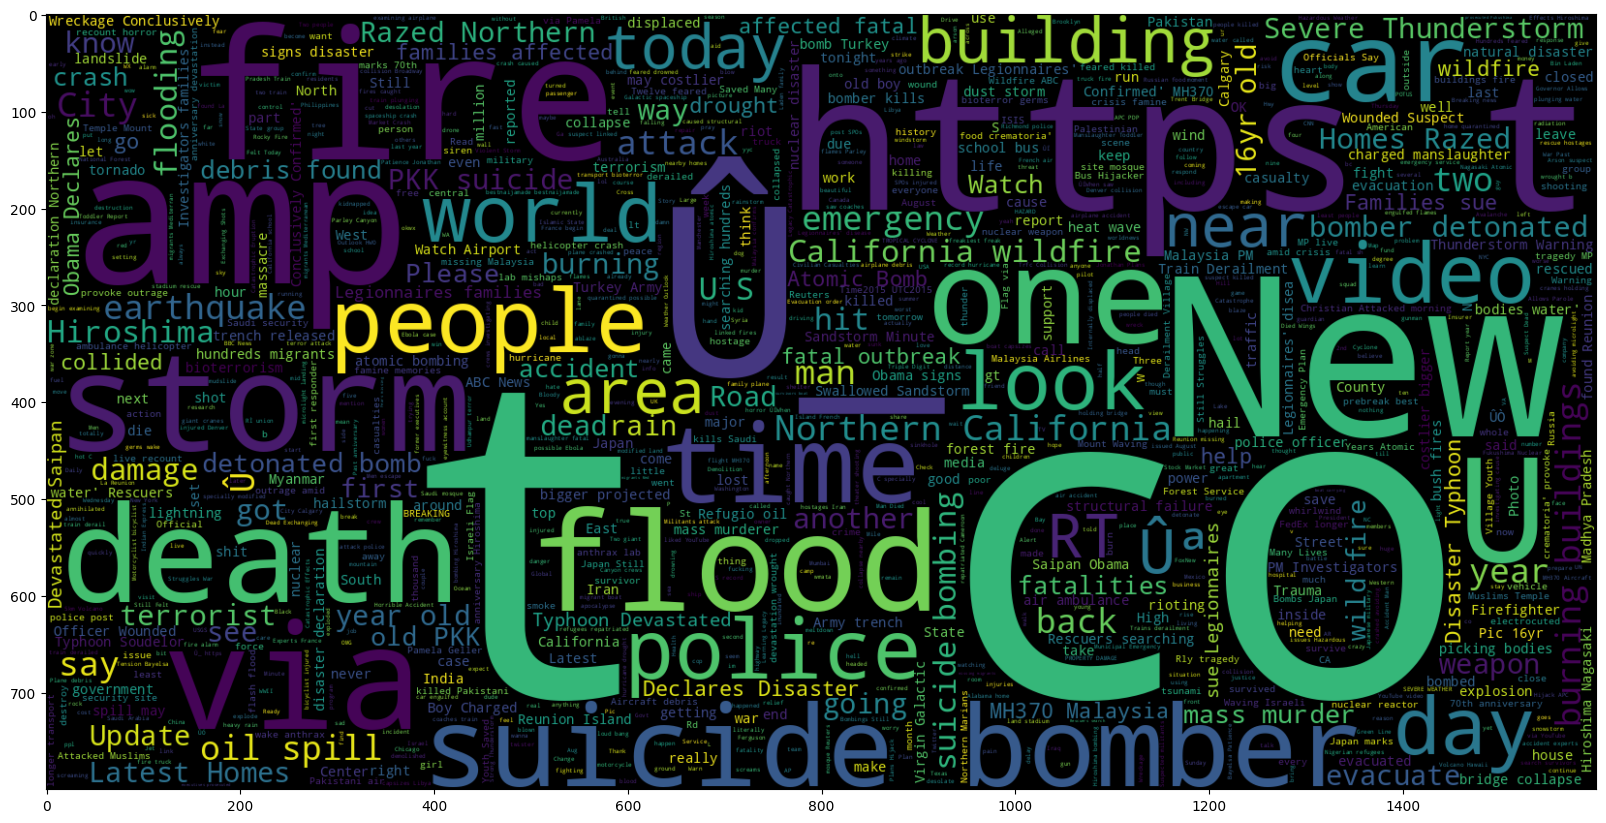

In [22]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Disaster tweets
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_1.text))
plt.imshow(wc , interpolation = 'bilinear')


## Plotting wordcloud of Normal Tweets

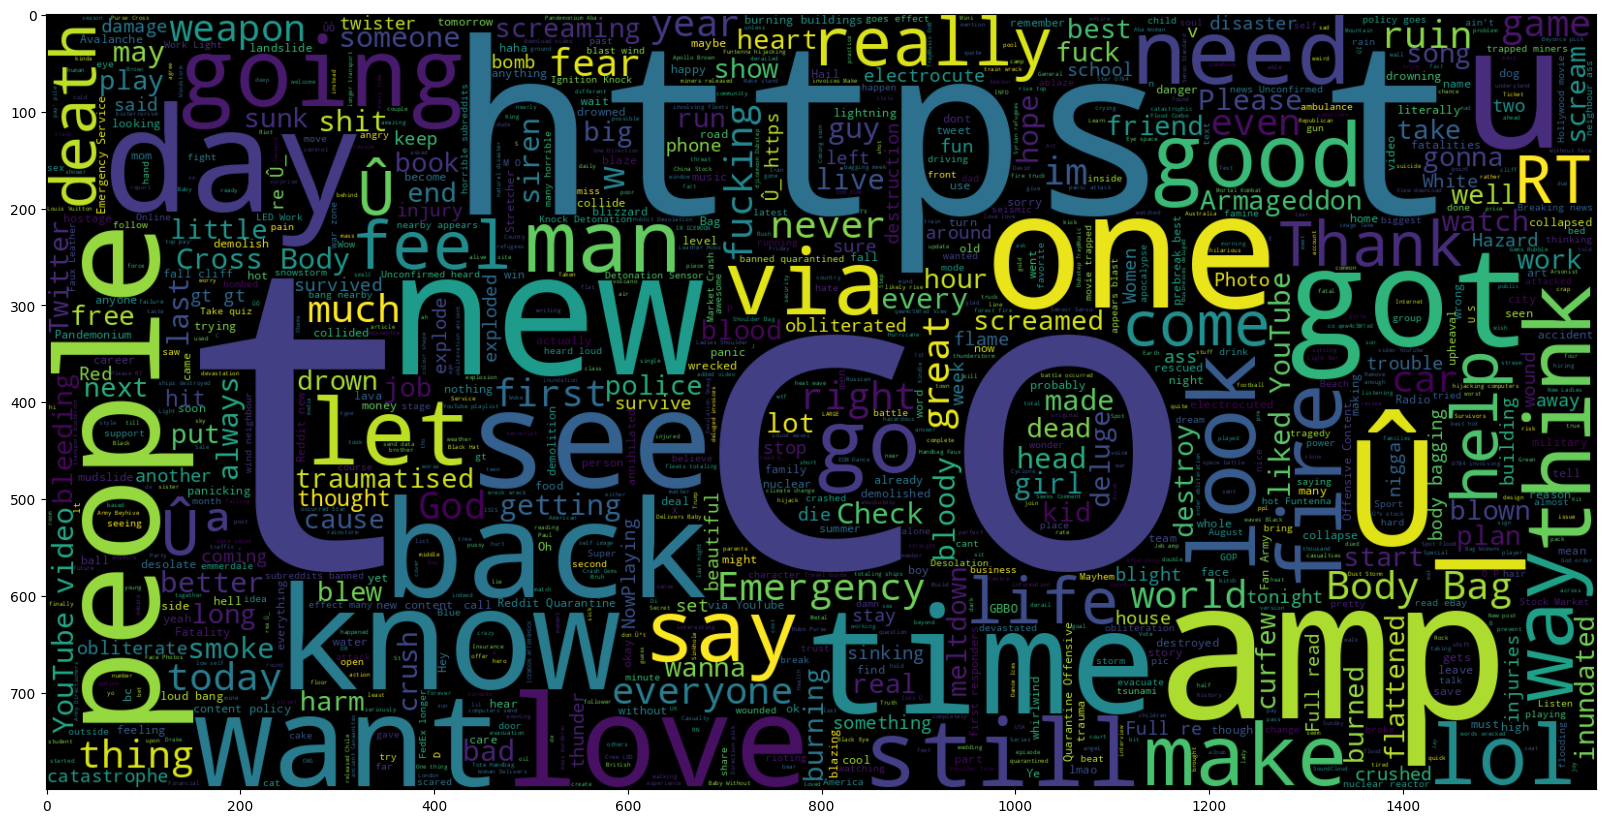

In [23]:
plt.figure(figsize = (20,20)) # Text that is Normal Tweets
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_0.text))
plt.imshow(wc , interpolation = 'bilinear')

## Data Cleaning and Preparation

In [24]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
#creating list of possible stopwords from nltk library
stop = stopwords.words('english')

def cleanTweet(txt):
  # lowercaing
    txt = txt.lower()
    # tokenization
    words = nltk.word_tokenize(txt)
  # removing stopwords & mennatizing the words
    words = ' '.join([lemma.lemmatize(word) for word in words if word not in (stop)])
    text = "".join(words)
  # removing non-alphabetic characters
    txt = re.sub('[^a-z]',' ',text)
    return txt


## Applying Clean Tweet Function on Tweets Text

In [25]:
df['cleaned_tweets'] = df['text'].apply(cleanTweet)
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  length                                     cleaned_tweets  
0       1      69       deed reason   earthquake may allah forgive u  
1       1      38            forest fire near la ronge sask   canada  
2       1     133  resident asked  shelter place   notified offic...  
3       1      65         people receive   wildfire evacuation or...  
4       1      88  got sent photo ruby   alaska smoke   wildfire ...

## Creating Feature & Target Variables

In [26]:
y = df.target
X=df.cleaned_tweets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)

## TF-IDF Vectorizer - Bi-Gram

In [28]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Multinomial Naive Bayes

In [29]:
## Model Fitting
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)



MultinomialNB()

## 10-Fold Cross Validation

In [30]:
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb2 = cross_val_score(estimator = mnb_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)
acc_mnb2.mean()

0.7922824302134648

## Model Prediction Test set

Model  Accuracy  Precision  Sensitivity  \
0  Multinomial Naive Bayes - TFIDF-Bigram  0.800394   0.858607     0.640673   

   Specificity  F1 Score  
0     0.920598    0.7338

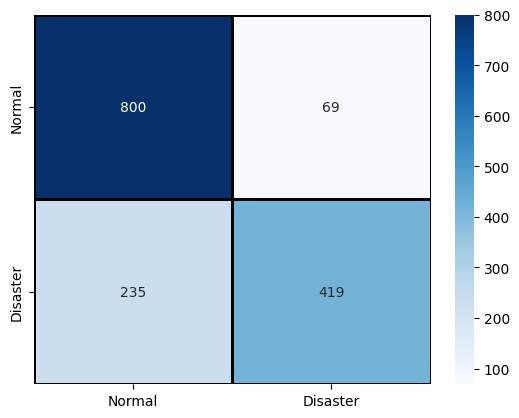

In [31]:
pred_mnb2 = mnb_tf.predict(tfidf_test_2)
CM=confusion_matrix(y_test,pred_mnb2)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)

acc= accuracy_score(y_test, pred_mnb2)

prec = precision_score(y_test, pred_mnb2)
rec = recall_score(y_test, pred_mnb2)
f1 = f1_score(y_test, pred_mnb2)


model_results =pd.DataFrame([['Multinomial Naive Bayes - TFIDF-Bigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])

model_results

## Passive Aggressive Classifier

In [32]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)

PassiveAggressiveClassifier()

## 10-Fold Cross Validation

In [33]:

kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_pass2 = cross_val_score(estimator = pass_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)
acc_pass2.mean()

0.7876847290640395

## Model Prediction

Model  Accuracy  Precision  \
0        Multinomial Naive Bayes - TFIDF-Bigram  0.800394   0.858607   
1  Passive Aggressive Classifier - TFIDF-Bigram  0.785292   0.745865   

   Sensitivity  Specificity  F1 Score  
0     0.640673     0.920598  0.733800  
1     0.758410     0.920598  0.752085

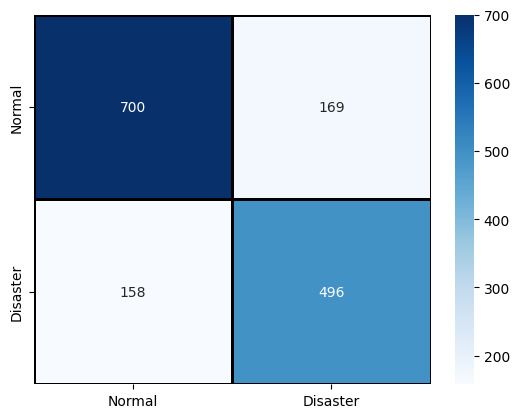

In [34]:
pred_pass2 = pass_tf.predict(tfidf_test_2)
CM=confusion_matrix(y_test,pred_pass2)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

acc = accuracy_score(y_test, pred_pass2)
prec = precision_score(y_test, pred_pass2)
rec = recall_score(y_test, pred_pass2)
f1 = f1_score(y_test, pred_pass2)

results =pd.DataFrame([['Passive Aggressive Classifier - TFIDF-Bigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
model_results = pd.concat([model_results, results], ignore_index=True)

model_results

## TF-IDF Vectorizer - Tri Gram

In [35]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer_3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer_3.transform(X_test)

## Multinomial Naive Bayes - Tri Gram

In [36]:
mnb_tf3 = MultinomialNB()
mnb_tf3.fit(tfidf_train_3, y_train)

MultinomialNB()

## 10-fold cross validation

In [37]:
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb3 = cross_val_score(estimator = mnb_tf, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)
acc_mnb3.mean()

0.7845648604269294

## Model Prediction

Model  Accuracy  Precision  \
0  Passive Aggressive Classifier - TFIDF-Bigram  0.785292   0.745865   
1       Multinomial Naive Bayes - TFIDF-Trigram  0.798424   0.866808   

   Sensitivity  Specificity  F1 Score  
0     0.758410     0.920598  0.752085  
1     0.626911     0.920598  0.727595

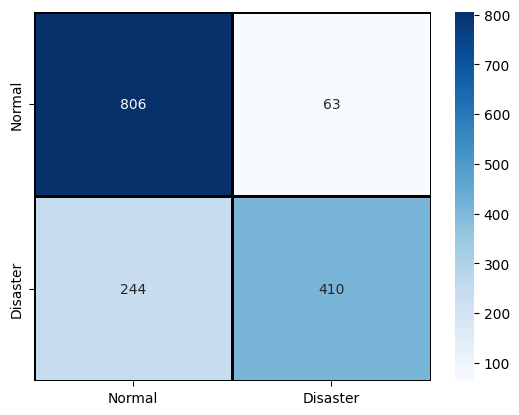

In [38]:
pred_mnb3 = mnb_tf3.predict(tfidf_test_3)
CM=confusion_matrix(y_test,pred_mnb3)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

acc = accuracy_score(y_test, pred_mnb3)
prec = precision_score(y_test, pred_mnb3)
rec = recall_score(y_test, pred_mnb3)
f1 = f1_score(y_test, pred_mnb3)

mod_results =pd.DataFrame([['Multinomial Naive Bayes - TFIDF-Trigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = pd.concat([results,mod_results], ignore_index=True)

results

## Passive Aggressive Classifier - Tri Gram

In [39]:
pass_tf3 = PassiveAggressiveClassifier()
pass_tf3.fit(tfidf_train_3, y_train)

## cross validation
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_pass3 = cross_val_score(estimator = pass_tf3, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)
acc_pass3.mean()

0.7908045977011493

Model  Accuracy  Precision  \
0  Passive Aggressive Classifier - TFIDF-Bigram  0.785292   0.745865   
1       Multinomial Naive Bayes - TFIDF-Trigram  0.798424   0.866808   
2       Multinomial Naive Bayes - TFIDF-Trigram  0.798424   0.866808   

   Sensitivity  Specificity  F1 Score  
0     0.758410     0.920598  0.752085  
1     0.626911     0.920598  0.727595  
2     0.626911     0.920598  0.727595

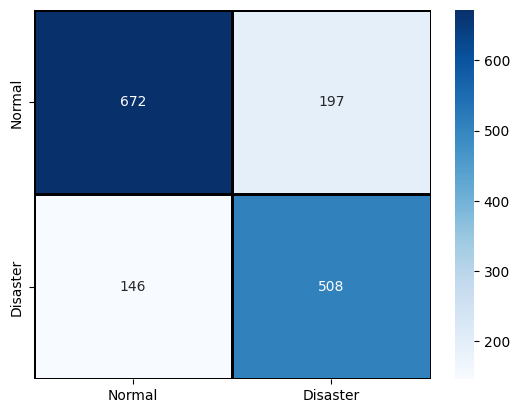

In [40]:
pred_pass3 = pass_tf3.predict(tfidf_test_3)
CM=confusion_matrix(y_test,pred_pass3)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

acc = accuracy_score(y_test, pred_pass3)
prec = precision_score(y_test, pred_pass3)
rec = recall_score(y_test, pred_pass3)
f1 = f1_score(y_test, pred_pass3)

mod1_results =pd.DataFrame([['Passive Aggressive Classifier - TFIDF-Trigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = pd.concat([results,mod_results], ignore_index=True)
results

## Most Informative Features

In [41]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472

    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)

In [42]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    feature_names = vectorizer.get_feature_names_out()
    if hasattr(classifier, 'coef_'):
        class_labels = classifier.classes_
        topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
        topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[:n]

        print(f"Class: {class_labels[0]}")
        for coef, feat in topn_class2:
            print(f"{feat}: {coef}")

        print(f"\nClass: {class_labels[1]}")
        for coef, feat in topn_class1:
            print(f"{feat}: {coef}")
    else:
        print("The classifier does not have 'coef_' attribute.")

# Example usage
most_informative_feature_for_binary_classification(tfidf_vectorizer_3, pass_tf3, n=10)


Class: 0
let: -2.197121726765143
bag: -2.0020747868908275
suicide bomb: -1.9124704328184936
love: -1.9058326997810289
hrqcjdovjz: -1.8058312457081103
http hrqcjdovjz: -1.8058312457081103
mishap http hrqcjdovjz: -1.8058312457081103
dianneg: -1.7116237186288794
dianneg gunshot: -1.7116237186288794
dianneg gunshot wound: -1.7116237186288794

Class: 1
killed: 2.6760769646560143
flood: 2.7829082905136726
bombing: 2.9075420194589934
forest: 2.91061911680072
wildfire: 3.0372992687659317
train: 3.046682355843078
building: 3.0914944083092624
california: 3.6330433916338083
hiroshima: 3.9203072026778365
http: 4.066633561877966


## Sample prediction

In [56]:
sentences = [
  "Just happened a terrible car crash",
    "Heard about #earthquake is different cities, stay safe everyone.",
    "No I don't like cold!",
    "@RosieGray Now in all sincerety do you think the UN would move to Israel if there was a fraction of a chance of being annihilated?"
  ]

tfidf_trigram = tfidf_vectorizer_3.transform(sentences)


predictions = pass_tf3.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label==1:
        target="Disaster Tweet"
        print("text:", text, "\nClass:", target)
        print()
    else:
        target="Normal Tweet"
        print("text:", text, "\nClass:", target)
        print()

text: Just happened a terrible car crash 
Class: Disaster Tweet

text: Heard about #earthquake is different cities, stay safe everyone. 
Class: Disaster Tweet

text: No I don't like cold! 
Class: Normal Tweet

text: @RosieGray Now in all sincerety do you think the UN would move to Israel if there was a fraction of a chance of being annihilated? 
Class: Normal Tweet



In [57]:
sentences = [
  "flood happeningnin jammu",
    "Heard about #earthquake is different cities, stay safe everyone.",
    "earthquake in assam",
    "Hi how are you?"
  ]

tfidf_trigram = tfidf_vectorizer_3.transform(sentences)


predictions = pass_tf3.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label==1:
        target="Disaster Tweet"
        print("text:", text, "\nClass:", target)
        print()
    else:
        target="Normal Tweet"
        print("text:", text, "\nClass:", target)
        print()

text: flood happeningnin jammu 
Class: Disaster Tweet

text: Heard about #earthquake is different cities, stay safe everyone. 
Class: Disaster Tweet

text: earthquake in assam 
Class: Disaster Tweet

text: Hi how are you? 
Class: Normal Tweet



In [72]:
!pip install streamlit

import streamlit as st

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [69]:
import joblib

# Assuming you have a trained TF-IDF vectorizer stored in `tfidf_vectorizer` and a trained classifier model stored in `classifier_model`

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer_3, 'tfidf_vectorizer_3.pkl')

# Save the classifier model
joblib.dump(pass_tf3, 'pass_tf3.pkl')


['pass_tf3.pkl']

In [73]:
import streamlit as st
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the vectorizer and model
vectorizer = joblib.load('/content/tfidf_vectorizer_3.pkl')
model = joblib.load('/content/pass_tf3.pkl')

# Function to classify the tweet
def classify_tweet(tweet_text):
    # Vectorize the input text
    text_vectorized = vectorizer.transform([tweet_text])
    # Predict the class
    prediction = model.predict(text_vectorized)
    return prediction[0]

# Streamlit UI
st.title('Disaster Tweet Classification')

tweet_text = st.text_input('Enter the tweet text:')
if st.button('Classify'):
    if tweet_text:
        prediction = classify_tweet(tweet_text)
        if prediction == 1:
            st.write('This is a disaster tweet.')
        else:
            st.write('This is not a disaster tweet.')
    else:
        st.write('Please enter a tweet text.')


2024-06-05 13:23:39.078 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-06-05 13:23:39.080 Session state does not function when running a script without `streamlit run`


In [74]:
%%writefile app1.py
import streamlit as st
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the vectorizer and model
vectorizer = joblib.load('/content/tfidf_vectorizer_3.pkl')
model = joblib.load('/content/pass_tf3.pkl')

# Function to classify the tweet
def classify_tweet(tweet_text):
    # Vectorize the input text
    text_vectorized = vectorizer.transform([tweet_text])
    # Predict the class
    prediction = model.predict(text_vectorized)
    return prediction[0]

# Streamlit UI
st.title('Disaster Tweet Classification')

tweet_text = st.text_input('Enter the tweet text:')
if st.button('Classify'):
    if tweet_text:
        prediction = classify_tweet(tweet_text)
        if prediction == 1:
            st.write('This is a disaster tweet.')
        else:
            st.write('This is not a disaster tweet.')
    else:
        st.write('Please enter a tweet text.')

Writing app1.py


In [ ]:
! pip install streamlit -q
!wget -q -O - ipv4.icanhazip.com
! streamlit run app1.py & npx localtunnel --port 8501

34.127.81.222


npx: installed 22 in 4.356s
your url is: https://honest-lions-shop.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.127.81.222:8501

